In [1]:
import collections
from torch.utils.data import TensorDataset
import numpy as np
from sklearn.neighbors import NearestNeighbors
import time
import os
import argparse
import math
import sys
import random
import pandas as pd
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from collections import Counter
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch
import psutil
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch.nn.init as init
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import shutil
import os
from joblib import dump,load
import Framework
import MemoryDataset
import Visualization

In [2]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seed = 42  
os.environ['PYTHONHASHSEED'] = str(seed)  
torch.manual_seed(seed)   
np.random.seed(seed)      
random.seed(seed)         
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
os.makedirs("images", exist_ok=True)
for i in range(10):
    os.makedirs(f"images/{i}", exist_ok=True)
os.makedirs("data", exist_ok=True)

In [4]:
parser = argparse.ArgumentParser() 
parser.add_argument("--n_epochs", type=int, default=1500, help="number of epochs of training") 
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0005, help="adam: learning rate") 
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--n_classes", type=int, default=10, help="number of classes for dataset")
parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=100, help="interval between image sampling")
parser.add_argument("--n_critic", type=int, default=5, help="number of training steps for discriminator per iter")
parser.add_argument("--gen_size", type=int, default=10, help="the sqrt number of gen size to save")
parser.add_argument("--total_gen_size", type=int, default=20000, help="the total size number of gen size need to save")
parser.add_argument("--visual", type=int, default=1, help="visual print number") 
parser.add_argument("--build_quality", type=int, default=0.6, help="the build_quality to save imgs")
parser.add_argument("--data_load", type=str, default='D:/jupyternotebook/X-1/CWT-IL-ACSAWGAN-GP/Data/CWRU/BR1_400_train_set_balance', help="load data")
parser.add_argument("--n_acc", type=int, default=0.6, help="save acc") # Filtering module setting
parser.add_argument("--n_att", type=int, default=1, help="Alternating training times")
parser.add_argument("--data_save", type=str, default='data', help="save data")
parser.add_argument("--img_save", type=str, default='images', help="save img")
opt = parser.parse_args([])
print(opt)
print(opt.lr)

Namespace(n_epochs=1500, batch_size=64, lr=0.0005, b1=0.5, b2=0.999, n_cpu=8, latent_dim=100, n_classes=10, img_size=32, channels=1, sample_interval=100, n_critic=5, gen_size=10, total_gen_size=20000, visual=1, build_quality=0.6, data_load='D:/jupyternotebook/X-1/CWT-IL-ACSAWGAN-GP/Data/CWRU/BR1_400_train_set_balance', n_acc=0.6, n_att=1, data_save='data', img_save='images')
0.0005


In [5]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32, 32)),  
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,))  
])
train_dataset = MemoryDataset.MemoryDataset(root=opt.data_load, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

In [6]:
model = Framework.DSEASMOTE().to(device)
gen_loss_function = nn.MSELoss()  
aux_loss_function = nn.CrossEntropyLoss()  
model_optim = torch.optim.Adam(model.parameters(), lr=opt.lr)

In [7]:
# Create the figure and axes
plt.figure(figsize=(10, 5))
plt.ion()
# Initialize loss list and statistics
losses = []
mean_cs_list = []
mean_pcc_list = []
mean_rmse_list = []
mean_js_list = []
mean_kl_list = []
mean_mmd_list = []
mean_emd_list = []
acc_list = []
save_mean_cs_list = []
save_mean_pcc_list = []
save_mean_rmse_list = []
save_mean_js_list = []
save_mean_kl_list = []
save_mean_mmd_list = []
save_mean_emd_list = []
save_acc_list = []
save_cs_total = []
save_pcc_total = []
save_rmse_total = []
save_js_total = []
save_kl_total = []
save_mmd_total = []
save_emd_total = []
save_img_num = 0 
correct_predictions = 0
total_generated_samples = 0
# class_count is a dictionary to store the number of generated images for each category
class_count = {i: 0 for i in range(opt.n_classes)}  # num_classes is the total number of categories
save_img_num = 0  # The file name to use to generate the image

<Figure size 1000x500 with 0 Axes>

D:\Anaconda3\envs\dl\lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
D:\Anaconda3\envs\dl\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
D:\Anaconda3\envs\dl\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Anaconda3\envs\dl\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.

Epoch: 1/1500,Batch:0/1,gen Loss: 1.0571, aux Loss:2.3036,Loss:3.3607,ACC:8.0000%
Generate image count: {0: 0, 1: 0, 2: 0, 3: 0, 4: 26, 5: 0, 6: 0, 7: 0, 8: 24, 9: 0},total gen:50
True Image Count: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5},total real:50
save img:0
pcc:[nan, nan, nan, nan, -0.3714, nan, nan, nan, -0.3256, nan]
cs:[nan, nan, nan, nan, 0.0116, nan, nan, nan, 0.1252, nan]
rmse:[nan, nan, nan, nan, 1.0563, nan, nan, nan, 0.9714, nan]
js:[nan, nan, nan, nan, 0.0725, nan, nan, nan, 0.0636, nan]
kl:[nan, nan, nan, nan, 0.3164, nan, nan, nan, 0.2786, nan]
mmd:[nan, nan, nan, nan, 0.4708, nan, nan, nan, 0.3645, nan]
emd:[nan, nan, nan, nan, 0.9007, nan, nan, nan, 0.8179, nan]
mean cs:0.0684,mean pcc:-0.34850000000000003,mean rmse:1.0138500000000001,mean js:0.06805,mean kl:0.2975,mean mmd:0.41764999999999997,mean emd:0.8593,save img num:0


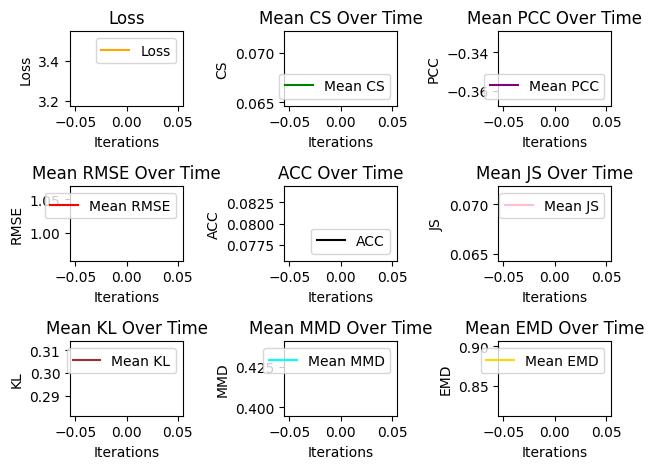

Epoch: 2/1500,Batch:0/1,gen Loss: 0.4013, aux Loss:2.3028,Loss:2.7041,ACC:11.0000%
Generate image count: {0: 0, 1: 0, 2: 4, 3: 27, 4: 19, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0},total gen:50
True Image Count: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5},total real:50
save img:0
pcc:[nan, nan, 0.7399, 0.8115, 0.8001, nan, nan, nan, nan, nan]
cs:[nan, nan, 0.6157, 0.4868, 0.4855, nan, nan, nan, nan, nan]
rmse:[nan, nan, 0.6031, 0.7189, 0.6842, nan, nan, nan, nan, nan]
js:[nan, nan, 0.0349, 0.0475, 0.0442, nan, nan, nan, nan, nan]
kl:[nan, nan, 0.1556, 0.2096, 0.1934, nan, nan, nan, nan, nan]
mmd:[nan, nan, 0.0082, 0.0705, 0.0639, nan, nan, nan, nan, nan]
emd:[nan, nan, 0.5513, 0.6713, 0.6381, nan, nan, nan, nan, nan]
mean cs:0.5293333333333333,mean pcc:0.7838333333333334,mean rmse:0.6687333333333334,mean js:0.042199999999999994,mean kl:0.1862,mean mmd:0.04753333333333334,mean emd:0.6202333333333333,save img num:0


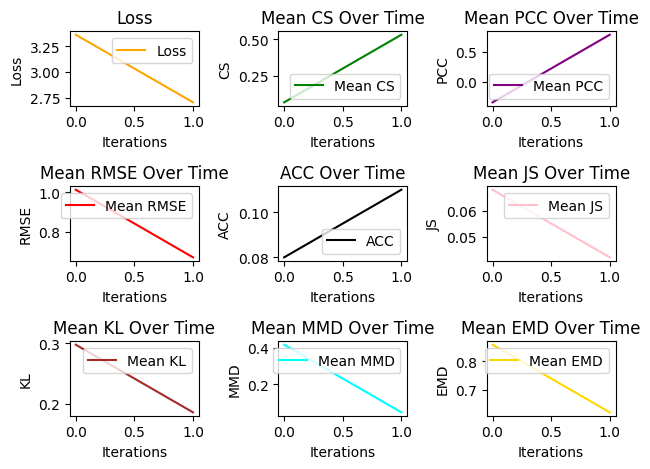

Epoch: 3/1500,Batch:0/1,gen Loss: 0.2703, aux Loss:2.3023,Loss:2.5726,ACC:11.3333%
Generate image count: {0: 0, 1: 0, 2: 26, 3: 24, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0},total gen:50
True Image Count: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5},total real:50
save img:0
pcc:[nan, nan, 0.8603, 0.8865, nan, nan, nan, nan, nan, nan]
cs:[nan, nan, 0.7597, 0.6491, nan, nan, nan, nan, nan, nan]
rmse:[nan, nan, 0.4946, 0.6231, nan, nan, nan, nan, nan, nan]
js:[nan, nan, 0.0195, 0.0277, nan, nan, nan, nan, nan, nan]
kl:[nan, nan, 0.0841, 0.1205, nan, nan, nan, nan, nan, nan]
mmd:[nan, nan, 0.0319, 0.1122, nan, nan, nan, nan, nan, nan]
emd:[nan, nan, 0.4212, 0.5371, nan, nan, nan, nan, nan, nan]
mean cs:0.7044,mean pcc:0.8734,mean rmse:0.55885,mean js:0.0236,mean kl:0.1023,mean mmd:0.07205,mean emd:0.47915,save img num:0


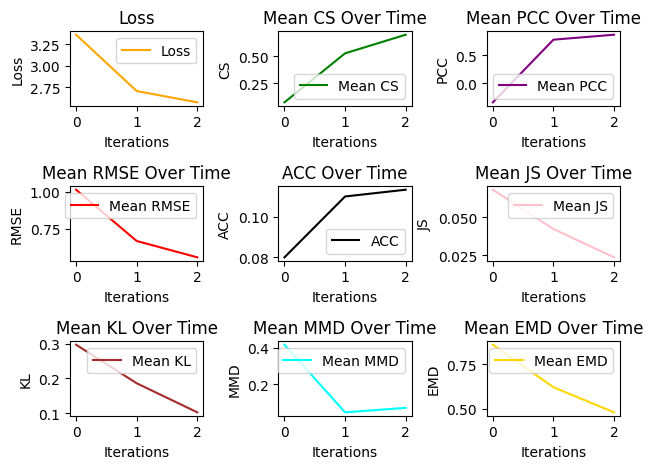

Epoch: 4/1500,Batch:0/1,gen Loss: 0.2497, aux Loss:2.2992,Loss:2.5489,ACC:13.0000%
Generate image count: {0: 0, 1: 0, 2: 8, 3: 31, 4: 0, 5: 0, 6: 11, 7: 0, 8: 0, 9: 0},total gen:50
True Image Count: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5},total real:50
save img:0
pcc:[nan, nan, 0.8385, 0.9172, nan, nan, 0.8355, nan, nan, nan]
cs:[nan, nan, 0.7352, 0.7036, nan, nan, 0.7718, nan, nan, nan]
rmse:[nan, nan, 0.5078, 0.5806, nan, nan, 0.4617, nan, nan, nan]
js:[nan, nan, 0.0177, 0.0202, nan, nan, 0.0157, nan, nan, nan]
kl:[nan, nan, 0.0768, 0.0872, nan, nan, 0.0678, nan, nan, nan]
mmd:[nan, nan, 0.0599, 0.1255, nan, nan, 0.0399, nan, nan, nan]
emd:[nan, nan, 0.3999, 0.4724, nan, nan, 0.3598, nan, nan, nan]
mean cs:0.7368666666666668,mean pcc:0.8637333333333334,mean rmse:0.5167,mean js:0.017866666666666666,mean kl:0.07726666666666666,mean mmd:0.0751,mean emd:0.4107,save img num:0


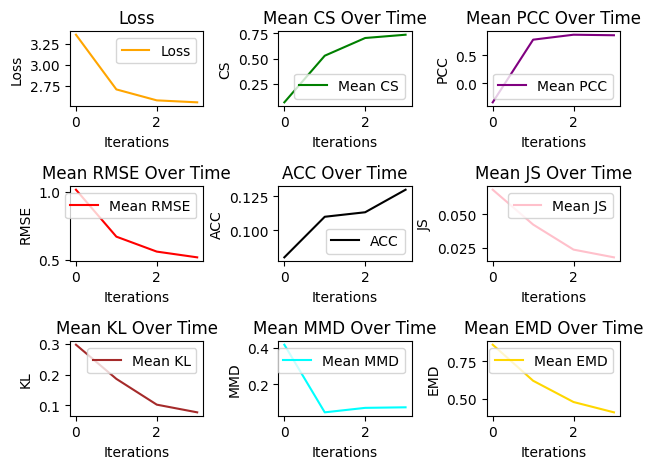

Epoch: 5/1500,Batch:0/1,gen Loss: 0.2482, aux Loss:2.2980,Loss:2.5461,ACC:12.4000%
Generate image count: {0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 49, 7: 0, 8: 0, 9: 0},total gen:50
True Image Count: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5},total real:50
save img:0
pcc:[nan, nan, 0.8567, nan, nan, nan, 0.8564, nan, nan, nan]
cs:[nan, nan, 0.7976, nan, nan, nan, 0.8011, nan, nan, nan]
rmse:[nan, nan, 0.4435, nan, nan, nan, 0.4346, nan, nan, nan]
js:[nan, nan, 0.0126, nan, nan, nan, 0.0127, nan, nan, nan]
kl:[nan, nan, 0.0539, nan, nan, nan, 0.0542, nan, nan, nan]
mmd:[nan, nan, 0.0403, nan, nan, nan, 0.0373, nan, nan, nan]
emd:[nan, nan, 0.3318, nan, nan, nan, 0.328, nan, nan, nan]
mean cs:0.79935,mean pcc:0.85655,mean rmse:0.43905,mean js:0.01265,mean kl:0.05405,mean mmd:0.0388,mean emd:0.32989999999999997,save img num:0


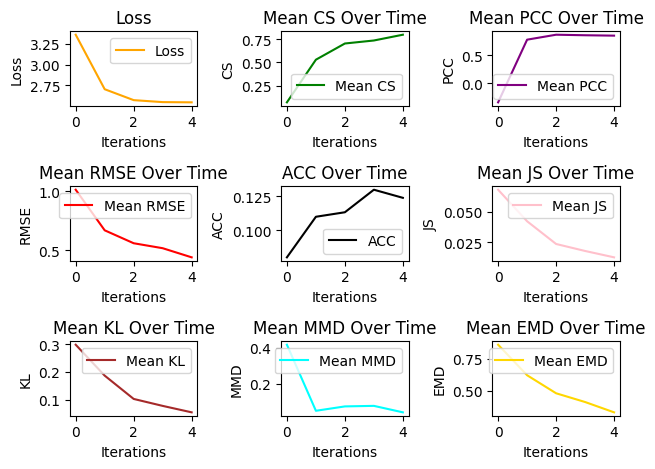

Epoch: 6/1500,Batch:0/1,gen Loss: 0.2441, aux Loss:2.2993,Loss:2.5434,ACC:12.0000%
Generate image count: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 50, 7: 0, 8: 0, 9: 0},total gen:50
True Image Count: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5},total real:50
save img:0
pcc:[nan, nan, nan, nan, nan, nan, 0.8583, nan, nan, nan]
cs:[nan, nan, nan, nan, nan, nan, 0.798, nan, nan, nan]
rmse:[nan, nan, nan, nan, nan, nan, 0.4383, nan, nan, nan]
js:[nan, nan, nan, nan, nan, nan, 0.0123, nan, nan, nan]
kl:[nan, nan, nan, nan, nan, nan, 0.053, nan, nan, nan]
mmd:[nan, nan, nan, nan, nan, nan, 0.045, nan, nan, nan]
emd:[nan, nan, nan, nan, nan, nan, 0.3149, nan, nan, nan]
mean cs:0.798,mean pcc:0.8583,mean rmse:0.4383,mean js:0.0123,mean kl:0.053,mean mmd:0.045,mean emd:0.3149,save img num:0


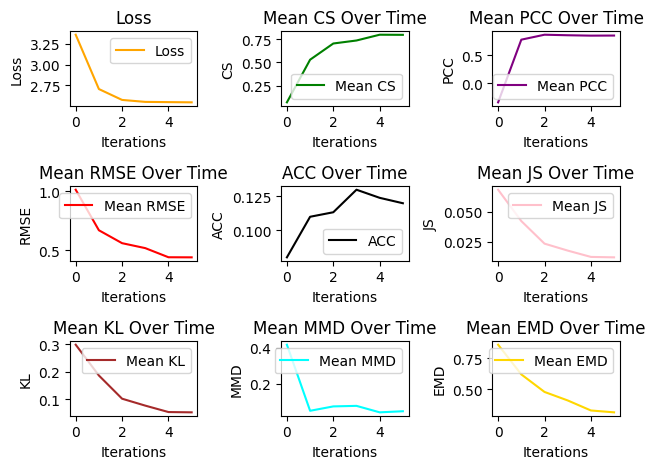

KeyboardInterrupt: 

In [8]:
#Training and synthesis part
for epoch in range(opt.n_epochs):
    gen_examples = {i: [] for i in range(10)}
    real_examples = {i: [] for i in range(10)}
    if save_img_num == opt.total_gen_size:
       print(f'High quality generated image data has been collected {save_img_num}! End!')
       Visualization.plot_metrics(losses, mean_cs_list, mean_pcc_list, mean_rmse_list, acc_list,mean_js_list,mean_kl_list,mean_mmd_list,mean_emd_list,save_path=os.path.join(opt.img_save, f'final_results_epoch_{epoch}.png'))
       print(f'save final epoch results pictures!')
       break

    for batch_idx, (images, labs) in enumerate(train_loader):
        model.zero_grad()

        images, labs = images.to(device), labs.to(device)

        x_hat, class_output = model(images)

        # Calculate loss
        gen_loss = gen_loss_function(x_hat, images)  # gen loss
        aux_loss = aux_loss_function(class_output, labs) # AFC-Loss
        loss = gen_loss + aux_loss
        loss.backward()
        
        model_optim.step()

        labs_one_hot = Visualization.one_hot(labs, opt.n_classes, device)  
        pred_labels = torch.argmax(class_output, dim=1)  
        correct_predictions += (pred_labels == labs).sum().item()  
        total_generated_samples += images.size(0)  
        accuracy = correct_predictions / total_generated_samples if total_generated_samples > 0 else 0 # G_acc

        #Store real image data by label distribution
        for r_i in range(len(labs)):
            r_label = labs[r_i].item()  # Use original tags directly
            real_examples[r_label].append(images[r_i])

        #Store generated image data and assign them by label
        for g_i in range(len(class_output)):
            g_label = torch.argmax(class_output[g_i]).item()  # Use argmax to get the predicted label
            gen_examples[g_label].append(x_hat[g_i])
            
        # Periodically output loss and count of generated images
        if batch_idx % opt.visual == 0:
           print(f'Epoch: {epoch+1}/{opt.n_epochs},Batch:{batch_idx}/{len(train_loader)},gen Loss: {gen_loss:.4f}, aux Loss:{aux_loss:.4f},Loss:{loss:.4f},ACC:{accuracy*100:.4f}%')
           gen_count = {key: len(value) for key, value in gen_examples.items()}
           real_count = {key: len(value) for key, value in real_examples.items()}
           print(f"Generate image count: {gen_count},total gen:{sum(gen_count.values())}")
           print(f"True Image Count: {real_count},total real:{sum(real_count.values())}")
           print(f"save img:{save_img_num}")

           pcc_total, cs_total, rmse_total, js_total, kl_total, mmd_total, emd_total = [], [], [], [], [], [], []
           for j in range(10):
               pcc_total.append(Visualization.pcc_similarity(gen_examples[j], real_examples[j], method="pad"))
               cs_total.append(Visualization.cosine_similarity(gen_examples[j], real_examples[j], method="pad"))
               rmse_total.append(Visualization.calculate_rmse(gen_examples[j], real_examples[j], method="pad"))
               js_total.append(Visualization.js_divergence(gen_examples[j],real_examples[j],method="pad"))
               kl_total.append(Visualization.kl_divergence(gen_examples[j],real_examples[j],method="pad"))
               mmd_total.append(Visualization.mmd(gen_examples[j],real_examples[j],method="pad"))
               emd_total.append(Visualization.emd(gen_examples[j],real_examples[j],method="pad"))
           print(f'pcc:{pcc_total}')
           print(f'cs:{cs_total}')
           print(f'rmse:{rmse_total}')
           print(f'js:{js_total}')
           print(f'kl:{kl_total}')
           print(f'mmd:{mmd_total}')
           print(f'emd:{emd_total}')
           mean_cs = np.nanmean(cs_total)
           mean_pcc = np.nanmean(pcc_total)
           mean_rmse = np.nanmean(rmse_total)
           mean_js = np.nanmean(js_total)
           mean_kl = np.nanmean(kl_total)
           mean_mmd = np.nanmean(mmd_total)
           mean_emd = np.nanmean(emd_total)
           print(f'mean cs:{mean_cs},mean pcc:{mean_pcc},mean rmse:{mean_rmse},mean js:{mean_js},mean kl:{mean_kl},mean mmd:{mean_mmd},mean emd:{mean_emd},save img num:{save_img_num}')
           losses.append(loss.item())
           mean_cs_list.append(mean_cs)
           mean_pcc_list.append(mean_pcc)
           mean_rmse_list.append(mean_rmse)
           mean_js_list.append(mean_js)
           mean_kl_list.append(mean_kl)
           mean_mmd_list.append(mean_mmd)
           mean_emd_list.append(mean_emd)
           acc_list.append(accuracy)
           Visualization.plot_metrics(losses, mean_cs_list, mean_pcc_list, mean_rmse_list,acc_list,mean_js_list,mean_kl_list,mean_mmd_list,mean_emd_list)

        pcc_save_total = []
        cs_save_total = []
        rmse_save_total = []
        js_save_total = []
        kl_save_total = []
        mmd_save_total = []
        emd_save_total = []
        for k in range(10): 
            pcc_save_total.append(Visualization.pcc_similarity(gen_examples[k],real_examples[k],method="pad"))
            cs_save_total.append(Visualization.cosine_similarity(gen_examples[k],real_examples[k],method="pad"))
            rmse_save_total.append(Visualization.calculate_rmse(gen_examples[k],real_examples[k],method="pad"))
            js_save_total.append(Visualization.js_divergence(gen_examples[k],real_examples[k],method="pad"))
            kl_save_total.append(Visualization.kl_divergence(gen_examples[k],real_examples[k],method="pad"))
            mmd_save_total.append(Visualization.mmd(gen_examples[k],real_examples[k],method="pad"))
            emd_save_total.append(Visualization.emd(gen_examples[k],real_examples[k],method="pad"))
        m_cs = np.nanmean(cs_save_total)
        m_pcc = np.nanmean(pcc_save_total)
        m_rmse = np.nanmean(rmse_save_total)
        m_js = np.nanmean(js_save_total)
        m_kl = np.nanmean(kl_save_total)
        m_mmd = np.nanmean(mmd_save_total)
        m_emd = np.nanmean(emd_save_total)

        if m_cs > opt.build_quality and save_img_num < opt.total_gen_size and accuracy > opt.n_acc:  # Filtering module
            save_mean_cs_list.append(m_cs)
            save_mean_pcc_list.append(m_pcc)
            save_mean_rmse_list.append(m_rmse)
            save_acc_list.append(accuracy)
            save_mean_js_list.append(m_js)
            save_mean_kl_list.append(m_kl)
            save_mean_mmd_list.append(m_mmd)
            save_mean_emd_list.append(m_emd)
            
            save_cs_total.append(cs_total)
            save_pcc_total.append(pcc_total)
            save_rmse_total.append(rmse_total)
            save_js_total.append(js_total)
            save_kl_total.append(kl_total)
            save_mmd_total.append(mmd_total)
            save_emd_total.append(emd_total)
            
            gen_labels = torch.argmax(class_output, dim=1)
            for gen_label in range(len(x_hat)):  
                g_label = gen_labels[gen_label].item()  
                if class_count[g_label] < 2000:  
                   class_dir = os.path.join(opt.img_save, str(g_label))
                   os.makedirs(class_dir, exist_ok=True)  
                   gen_img_path = os.path.join(class_dir, f'gen_img_{save_img_num}.png')
                   save_image(x_hat[gen_label].cpu(), gen_img_path)  
                   class_count[g_label] += 1  
                   save_img_num += 1  

            print(f'Saving images...,we have save {save_img_num} gen imgs and {len(save_mean_cs_list)} data! The epoch is {epoch}.The batch size is {i}.mean cs:{m_cs},mean pcc:{m_pcc},mean rmse:{m_rmse},mean js:{m_js},mean kl:{m_kl},mean mmd:{m_mmd},mean emd:{m_emd},save acc:{accuracy*100}%')
            print(class_count)

    checkpoint_path = os.path.join(opt.data_save, f'checkpoint.pth')
    torch.save({
        'epoch': epoch,
        'encoder_state_dict': model.state_dict(),
        'model_optim_state_dict': model_optim.state_dict(),
        'loss': loss.item(),
        'accuracy': accuracy,
    }, checkpoint_path)

    if epoch == opt.n_epochs - 1:
       Visualization.plot_metrics(losses, mean_cs_list, mean_pcc_list, mean_rmse_list, acc_list,mean_js_list,mean_kl_list,mean_mmd_list,mean_emd_list,save_path=os.path.join(opt.img_save, f'final_results_epoch_{epoch}.png'))
       print(f'save final epoch results pictures!')

plt.ioff()
plt.show()

In [ ]:
mean_cs = np.nanmean(save_mean_cs_list)
mean_pcc = np.nanmean(save_mean_pcc_list)
mean_rmse = np.nanmean(save_mean_rmse_list)
mean_js = np.nanmean(save_mean_js_list)
mean_kl = np.nanmean(save_mean_kl_list)
mean_mmd = np.nanmean(save_mean_mmd_list)
mean_emd = np.nanmean(save_mean_emd_list)
mean_acc = np.nanmean(save_acc_list)
data = {
    'DSEA-SMOTE': [mean_cs],
    'others': [None],  
}
df = pd.DataFrame(data, index=['mean_cs'])
df.loc['mean_pcc'] = [mean_pcc, None]
df.loc['mean_rmse'] = [mean_rmse, None]
df.loc['mean_acc'] = [mean_acc,None]
df.loc['mean_js'] = [mean_js, None]
df.loc['mean_kl'] = [mean_kl, None]
df.loc['mean_mmd'] = [mean_mmd, None]
df.loc['mean_emd'] = [mean_emd, None]
df.to_csv(os.path.join(opt.data_save,'training_results.csv'), index=True)
print("Training results saved to training_results.csv")

In [ ]:
dump(save_mean_cs_list,'data/save_mean_cs_list')
dump(save_mean_pcc_list,'data/save_mean_pcc_list')
dump(save_mean_rmse_list,'data/save_mean_rmse_list')
dump(save_acc_list,'data/save_acc_list')
dump(save_mean_js_list,'data/save_mean_js_list')
dump(save_mean_kl_list,'data/save_mean_kl_list')
dump(save_mean_mmd_list,'data/save_mean_mmd_list')
dump(save_mean_emd_list,'data/save_mean_emd_list')
dump(save_cs_total,'data/save_cs_total')
dump(save_pcc_total,'data/save_pcc_total')
dump(save_rmse_total,'data/save_rmse_total')
dump(save_js_total,'data/save_js_total')
dump(save_kl_total,'data/save_kl_total')
dump(save_mmd_total,'data/save_mmd_total')
dump(save_emd_total,'data/save_emd_total')
print('save over')

In [ ]:
folder_path = opt.img_save
output_filename = 'gen_img_save'
shutil.make_archive(output_filename, 'zip', folder_path)
print(f'The folder is packed into a compressed file {output_filename}.zip')

In [ ]:
folder_path_1 = opt.data_save
output_filename_1 = 'gen_data_save'
shutil.make_archive(output_filename_1, 'zip', folder_path_1)
print(f'The folder is packed into a compressed file {output_filename_1}.zip')